# Комментарий от ревьюера

~~Мария, привет! Меня зовут Влада, я посмотрела твой проект — работа отличная, но есть некоторые замечания. Ниже в файле ты найдешь мои комментарии: <font color='green'>зеленый цвет — «все отлично»; </font> <font color='blue'>синий — «хорошо, но можно лучше»; </font> <font color='red'>красный — «нужно исправить».</font> Комментарии в самом коде я отделяю знаками «###».~~

Мария, спасибо за доработки, задание засчитываю. Комментарии выделены цветом, как раньше.

<font color='purple'> Добрый день!

Спасибо за подробный фидбек и советы, внесла изменения и дополнения в проект. В шаге, где работаем с моделями, добавила вариант с делением на обучающую, валидационную и тестовую выборки - этот вариант находится после соответствующего совета-комментария. 
    Раздел с кластеризацией переделала. </font>

## Аналитика для сети фитнес-центров

**Описание задачи**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.
Чтобы бороться с оттоком клиентов, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

Необходимо:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
     1. выделить целевые группы клиентов;
     2. предложить меры по снижению оттока;
     3. определить другие особенности взаимодействия с клиентами.

**Описание данных**

Файл `/datasets/gym_churn.csv`содержит данные на месяц до оттока и факт оттока на определённый месяц. 
Набор данных включает следующие поля:

- **Churn** — факт оттока в текущем месяце;

Текущие поля в датасете

Данные пользователя за предыдущий до проверки факта оттока месяц:
- **gender** — пол
- **Near_Location** — проживание или работа в районе, где находится фитнес-центр
- **Partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- **Phone** — наличие контактного телефона
- **Age** — возраст
- **Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- **Contract_period** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- **Month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах)
- **Group_visits** — факт посещения групповых занятий
- **Avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента
- **Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц
- **Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

### Шаг 1: Загрузка данных


In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### [Шаг 2. Исследовательский анализ данных (EDA)](#2)

 - [Посмотрим, есть ли в датасете отсутствующие признаки, изучим средние значения и стандартные отклонения](#2.1)
 - [Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался ](#2.2)
 - [Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)](#2.3)
 - [Построим матрицу корреляций и отобразим её](#2.4)

<a name="2.1"> Проверим данные на предмет пропущенных значений:</a>

In [3]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропущенных значений нет. 

<a name="2.2"> Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. </a>

In [5]:
churn_mean = gym_churn.groupby('Churn').mean()
churn_mean = churn_mean.reset_index()
churn_mean

,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


<a name="2.3"> Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток) </a>

Разделим данные на признаки (X) и целевую переменную (y):

In [6]:
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

Разделим признаки на бинарные и количественные, а также переформатируем таблицу `churn_mean` для отрисовки barplot:

In [7]:
bin_feat = ['Churn', 'gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']
discrete = ['Contract_period', 'Month_to_end_contract']
num_feat = set(X.columns) - set(bin_feat) - set(discrete)

churn_mean = churn_mean [bin_feat]
feat_churn = churn_mean.melt(id_vars= ['Churn'], var_name='feature', value_name = 'value')
feat_churn.replace({'Churn': {0: 'остались', 1: 'ушли'}}, inplace = True)
feat_churn

,Churn,feature,value
0,остались,gender,0.510037
1,ушли,gender,0.510839
2,остались,Near_Location,0.873086
3,ушли,Near_Location,0.768143
4,остались,Partner,0.534195
5,ушли,Partner,0.355325
6,остались,Promo_friends,0.353522
7,ушли,Promo_friends,0.183789
8,остались,Phone,0.903709
9,ушли,Phone,0.902922


Распределение бинарных признаков проиллюстрируем на графике barplot:

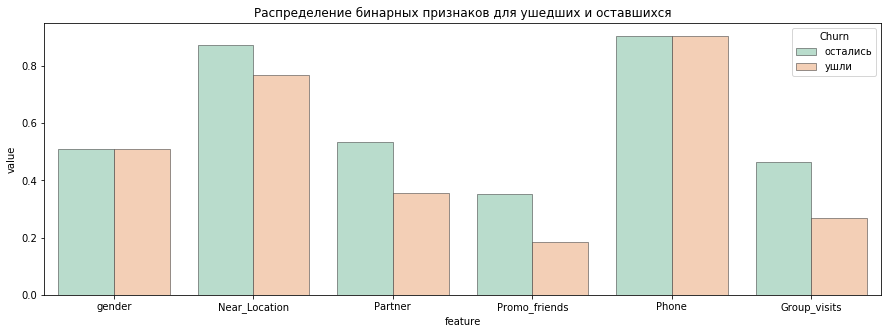

In [9]:
no_churn = gym_churn[gym_churn['Churn'] == 0]
churn = gym_churn[gym_churn['Churn'] == 1]

plt.figure(figsize=(15, 5))
sns.barplot(x = 'feature',  hue="Churn", y = 'value', data = feat_churn, palette = 'Pastel2', linewidth=0.5,
                  edgecolor=".2")
plt.title('Распределение бинарных признаков для ушедших и оставшихся')
plt.show()

<font color='purple'> **Благодарю за совет по выбору графика для дискретных признаков!** </font>

Для дискретных признаков с малым числом принимаемых значений изобразим гистограммы с распределением вероятностей: 

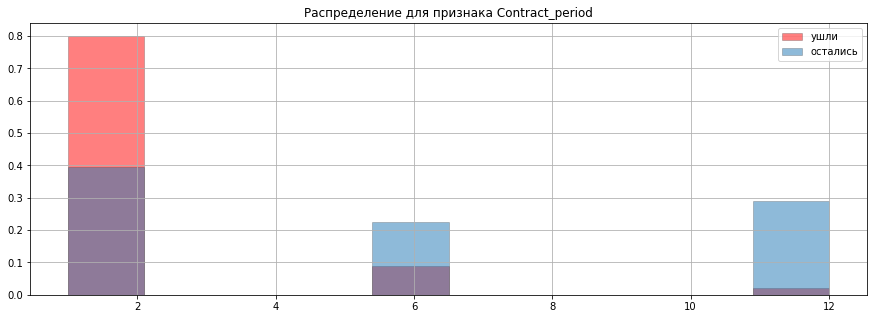

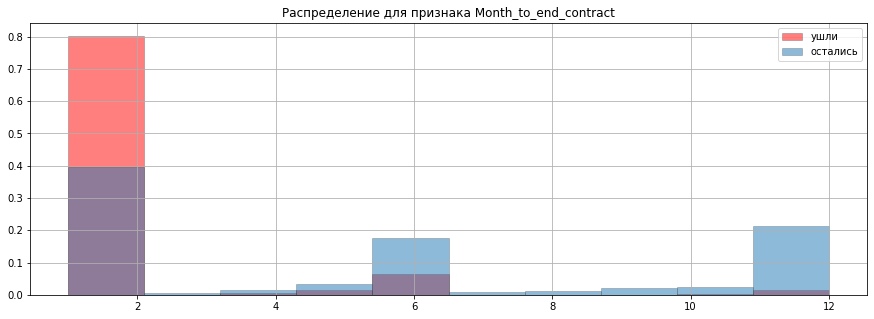

In [10]:
for col in discrete:
    plt.figure(figsize=(15, 5))
    churn[col].hist(density=True, color = 'r', alpha = 0.5, linewidth=0.5,
                  edgecolor=".2")
    no_churn[col].hist(density=True, alpha = 0.5, linewidth=0.5,
                  edgecolor=".2")
    plt.legend(labels = ('ушли', 'остались'))
    plt.title('Распределение для признака ' + col)
    plt.show()

<font color='blue'>Ширина столбиков получилась не 1, а чуть больше, поэтому и высоты не совсем корректные (не соответствуют распределениям вероятностей). Чтобы себя проверить, высоты столбиков, например, для 'Contract_period' с churn=1 должны быть churn['Contract_period'].value_counts(normalize=True). 

Надо было явно задать границы столбиков: *.hist(..., bins=range(1, 13)) или *.hist(..., bins=[x-0.5 for x in range(1, 13)]) (чтобы центры столбиков были в точках 1,2,..12).
</font>


Для количественных признаков построим столбчатые гистограммы:

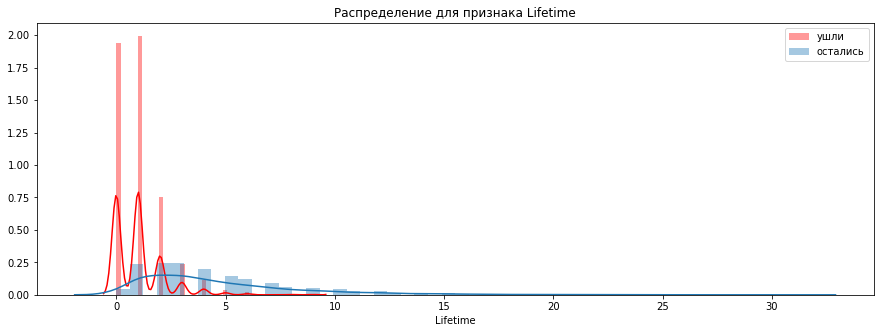

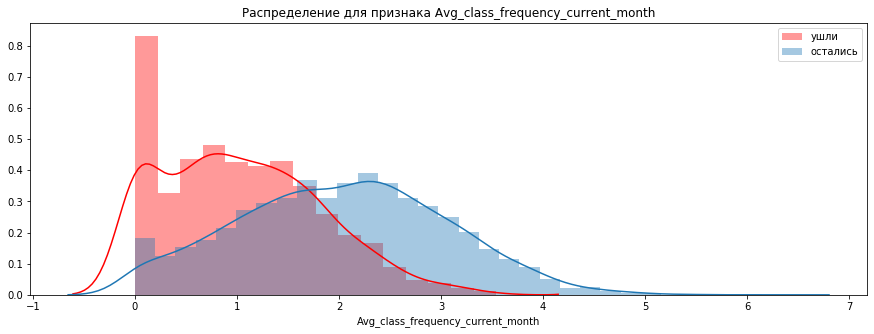

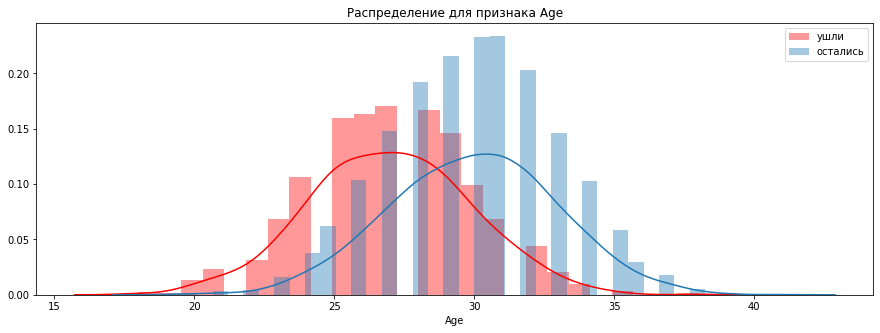

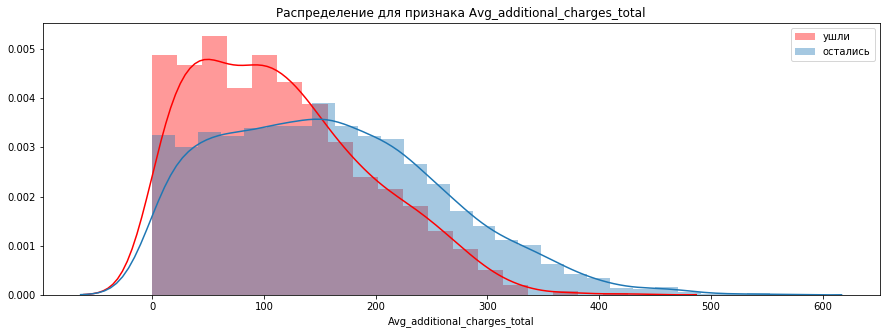

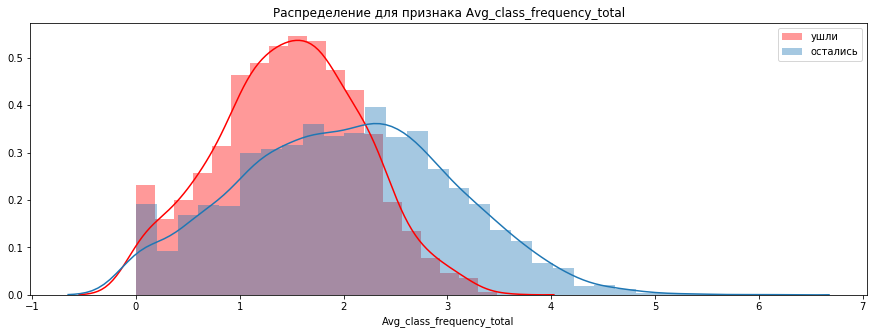

In [11]:


for col in num_feat:
    plt.figure(figsize=(15, 5))
    sns.distplot(churn[col], color = 'r')
    sns.distplot(no_churn[col])    
    plt.legend(labels = ('ушли', 'остались'))
    plt.title('Распределение для признака ' + col)
    plt.show() 

Глядя на получившиеся распределения, можно предположить, что
 - нет зависимости между уходом клиента и его полом или наличием его телефона в базе клиентов
 - вероятно, есть связь между уходом клиента и тем, являлся ли клиент сотрудником компании-партнера, пришел ли он по акции "приведи друга", живет/работает ли он недалеко от центра, посещал ли групповые занятия
 - у ушедших клиентов в подавляющем большинстве случаев был короткий абонемент на месяц
 - частота посещения зала у ушедших в среднем была ниже, чем у тех, кто остался
 - ушедшие клиенты в среднем моложе оставшихся
 - распределение признака lifetime у ушедших клиентов концентрируется в районе 0-1-2 месяцев - это может быть обусловлено короткими абонементами у этих клиентов, и, вероятно, это тот срок, которого недостаточно для конвертации клиента в постоянного пользователя центра
 - в среднем траты на доп.услуги ниже у ушедших клиентов

<font color='green'>Графики наглядные, молодец. </font>

<font color='blue'>~~Для дискретных признаков с малым числом принимаемых значений (например, Contract_period) стоило изобразить гистограммы с распределением вероятностей: *.hist() с параметрами density=True и с шириной столбиков, равной 1. В этом случае гистограмма нормируется так, чтобы суммарная высота столбиков была равна 1.~~</font>


<font color='purple'> **Выше воспользовалась Вашим советом, благодарю!** </font>

<a name="2.4"> Построим корреляционную матрицу числовых признаков набора данных и отобразим её:  </a>

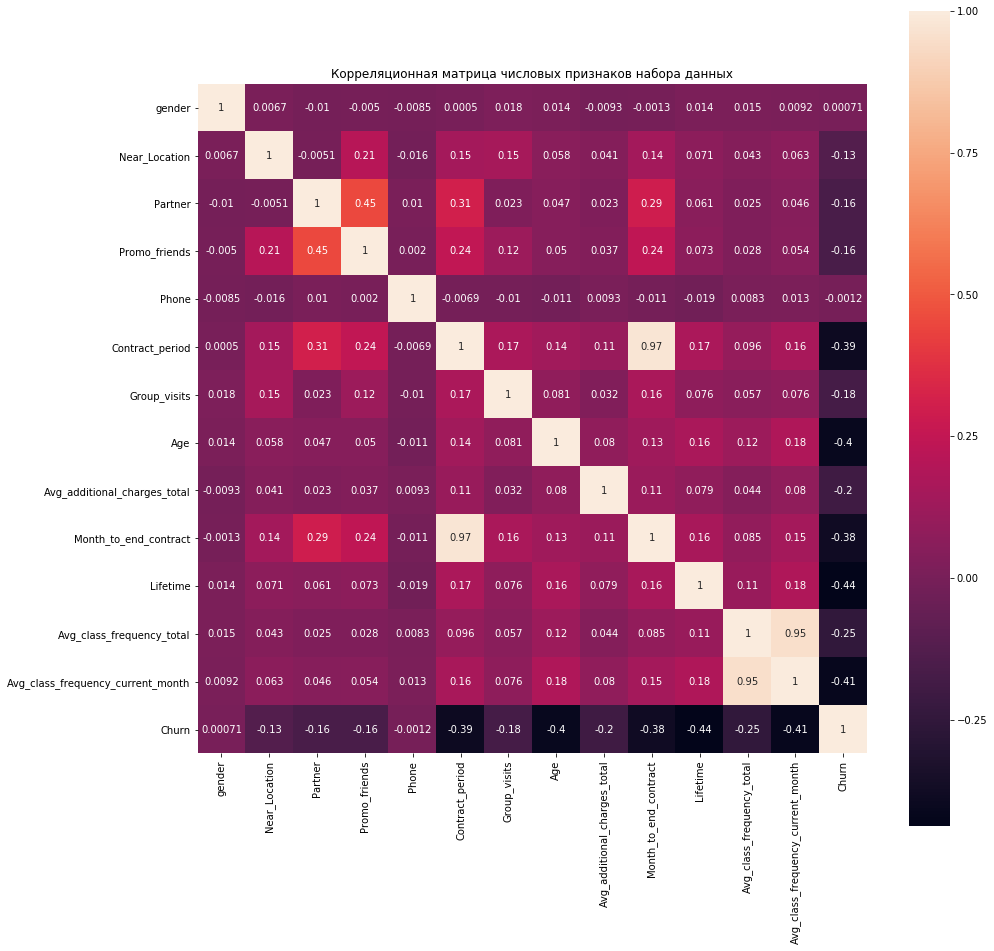

In [12]:
corr =  gym_churn.corr() 
plt.subplots(figsize=(15, 15))
sns.heatmap(corr, square = True, annot = True)
plt.title('Корреляционная матрица числовых признаков набора данных')
plt.show()

Анализируя матрицу корреляций, можно заключить, что нет признаков, явно коррелирующих с целевой переменной. Есть две пары скоррелированных признаков: `'Contract_period'` и `'Month_to_end_contract'`, `'Avg_class_frequency_total'` и `'Avg_class_frequency_current_month'`.

Ввиду характера выбираемых в следующем шаге моделей, нет проблемы в том, чтобы оставить скоррелированные признаки в выборке.

<font color='green'>Хорошо, все правильно. </font>


### [Шаг 3. Постройте модель прогнозирования оттока пользователей](#3)


Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:
- [Разбъем данные на обучающую и валидационную выборку функцией train_test_split()](#3.1)
- [Обучим модель на train-выборке любыми двумя способами:](#3.2)
     - логистической регрессией
     - случайным лесом
- [Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?](#3.3)

<a name="3.1"> Разoбъем данные на обучающую и тестовую выборку функцией train_test_split(): </a>

In [13]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)

<a name="3.2"> Зададим две модели - первую как элемент класса RandomForestClassifier() и вторую как элемент класса LogisticRegression(). Обучим модель на train-выборке: </a> 

In [14]:
# случайный лес
model_1 = RandomForestClassifier(random_state = 0)
model_1.fit(X_train_, y_train)

# логистическая регрессия
model_2 = LogisticRegression(random_state=0)
model_2.fit(X_train_, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Воспользуемся обученными моделями, чтобы сделать прогнозы:

In [15]:
predictions_1 = model_1.predict(X_test_)
predictions_2 = model_2.predict(X_test_)

<a name="3.3"> Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.</a>

In [16]:
print('Accuracy для RandomForestClassifier: {:.2f}'.format(accuracy_score(y_test, predictions_1)))
print('Accuracy для LogisticRegression: {:.2f}'.format(accuracy_score(y_test, predictions_2)))
print('Precision для RandomForestClassifier: {:.2f}'.format(precision_score(y_test, predictions_1)))
print('Precision для LogisticRegression: {:.2f}'.format(precision_score(y_test, predictions_2)))
print('Recall для RandomForestClassifier: {:.2f}'.format(recall_score(y_test, predictions_1)))
print('Recall для LogisticRegression: {:.2f}'.format(recall_score(y_test, predictions_2)))
print('F1 для RandomForestClassifier: {:.2f}'.format(f1_score(y_test, predictions_1)))
print('F1 для LogisticRegression: {:.2f}'.format(f1_score(y_test, predictions_2)))

Accuracy для RandomForestClassifier: 0.91
Accuracy для LogisticRegression: 0.92
Precision для RandomForestClassifier: 0.83
Precision для LogisticRegression: 0.85
Recall для RandomForestClassifier: 0.78
Recall для LogisticRegression: 0.83
F1 для RandomForestClassifier: 0.80
F1 для LogisticRegression: 0.84


Метрики модели на основе логистической регрессии оказались выше, то есть логистическая регрессия в нашем случае работает лучше.

<font color='green'>Да, логистическая регрессия показала себя немного лучше. </font>

<font color='blue'>~~Этого не сказано в задании, но более корректно было бы поделить выборку на 3 части: обучающую, валидационную и тестовую. На обучающей выборке настраивать модели (fit), на валидационной – проверять качество всех моделей и выбирать лучшую, на тестовой – оценивать качество итоговой модели. Было бы неплохо перебрать несколько значений гиперпараметров для каждой модели (например, для RandomForestRegressor перебрать разные значения n_estimators).~~</font>

<font color='purple'> Спасибо за замечание, согласна - необходимо проверить, покажет ли логистическая регрессия такой же хороший результат на тестовой выборке. Также рассмотрим модели с разными значениям параметров. </font>

Разoбъем данные на обучающую, валидационную и тестовую выборку функцией train_test_split() (в пропорции 60-20-20%):

In [17]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=0)

<font color='green'>Деление на выборки проведено корректно. </font>


Зададим две модели - первую как элемент класса RandomForestClassifier() и вторую как элемент класса LogisticRegression(). Обучим модель на train-выборке:

In [18]:
# случайный лес n_estimators = 100
model_1_1 = RandomForestClassifier(random_state = 0, n_estimators = 100)
model_1_1.fit(X_train, y_train)

# случайный лес n_estimators = 50
model_1_2 = RandomForestClassifier(random_state = 0, n_estimators = 50)
model_1_2.fit(X_train, y_train)

# случайный лес n_estimators = 400
model_1_3 = RandomForestClassifier(random_state = 0, n_estimators = 400)
model_1_3.fit(X_train, y_train)

# логистическая регрессия c penalty = 'l1'
model_2_l1 = LogisticRegression(random_state=0, penalty = 'l1')
model_2_l1.fit(X_train, y_train)

# логистическая регрессия c penalty = 'l2'
model_2_l2 = LogisticRegression(random_state=0, penalty = 'l2')
model_2_l2.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Воспользуемся обученными моделями, чтобы сделать прогнозы:

In [19]:
predictions_1_1 = model_1_1.predict(X_val)
predictions_1_2 = model_1_2.predict(X_val)
predictions_1_3 = model_1_3.predict(X_val)

predictions_2_l1 = model_2_l1.predict(X_val)
predictions_2_l2 = model_2_l2.predict(X_val)

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [20]:
print('Accuracy для RandomForestClassifier(n_estimators = 100): {:.2f}'.format(accuracy_score(y_val,predictions_1_1)))
print('Accuracy для RandomForestClassifier(n_estimators = 50 ): {:.2f}'.format(accuracy_score(y_val, predictions_1_2)))
print('Accuracy для RandomForestClassifier(n_estimators = 400): {:.2f}'.format(accuracy_score(y_val, predictions_1_3)))
print('Accuracy для LogisticRegression(penalty = "l1"): {:.2f}'.format(accuracy_score(y_val, predictions_2_l1)))
print('Accuracy для LogisticRegression(penalty = "l2"): {:.2f}'.format(accuracy_score(y_val, predictions_2_l2)))
print('  ')
print('Precision для RandomForestClassifier(n_estimators = 100): {:.2f}'.format(precision_score(y_val, predictions_1_1)))
print('Precision для RandomForestClassifier(n_estimators = 50 ): {:.2f}'.format(precision_score(y_val, predictions_1_2)))
print('Precision для RandomForestClassifier(n_estimators = 400): {:.2f}'.format(precision_score(y_val, predictions_1_3)))
print('Precision для LogisticRegression(penalty = "l1"): {:.2f}'.format(precision_score(y_val, predictions_2_l1)))
print('Precision для LogisticRegression(penalty = "l2"): {:.2f}'.format(precision_score(y_val, predictions_2_l2)))
print('  ')
print('Recall для RandomForestClassifier(n_estimators = 100): {:.2f}'.format(recall_score(y_val, predictions_1_1)))
print('Recall для RandomForestClassifier(n_estimators = 50 ): {:.2f}'.format(recall_score(y_val, predictions_1_2)))
print('Recall для RandomForestClassifier(n_estimators = 400): {:.2f}'.format(recall_score(y_val, predictions_1_3)))
print('Recall для LogisticRegression(penalty = "l1"): {:.2f}'.format(recall_score(y_val, predictions_2_l1)))
print('Recall для LogisticRegression(penalty = "l2"): {:.2f}'.format(recall_score(y_val, predictions_2_l2)))
print('  ')

print('F1 для RandomForestClassifier(n_estimators = 100): {:.2f}'.format(f1_score(y_val, predictions_1_1)))
print('F1 для RandomForestClassifier(n_estimators = 50 ): {:.2f}'.format(f1_score(y_val, predictions_1_2)))
print('F1 для RandomForestClassifier(n_estimators = 400): {:.2f}'.format(f1_score(y_val, predictions_1_3)))
print('F1 для LogisticRegression(penalty = "l1"): {:.2f}'.format(f1_score(y_val, predictions_2_l1)))
print('F1 для LogisticRegression(penalty = "l2"): {:.2f}'.format(f1_score(y_val, predictions_2_l2)))



Accuracy для RandomForestClassifier(n_estimators = 100): 0.92
Accuracy для RandomForestClassifier(n_estimators = 50 ): 0.92
Accuracy для RandomForestClassifier(n_estimators = 400): 0.92
Accuracy для LogisticRegression(penalty = "l1"): 0.93
Accuracy для LogisticRegression(penalty = "l2"): 0.93
  
Precision для RandomForestClassifier(n_estimators = 100): 0.89
Precision для RandomForestClassifier(n_estimators = 50 ): 0.89
Precision для RandomForestClassifier(n_estimators = 400): 0.87
Precision для LogisticRegression(penalty = "l1"): 0.90
Precision для LogisticRegression(penalty = "l2"): 0.89
  
Recall для RandomForestClassifier(n_estimators = 100): 0.80
Recall для RandomForestClassifier(n_estimators = 50 ): 0.80
Recall для RandomForestClassifier(n_estimators = 400): 0.80
Recall для LogisticRegression(penalty = "l1"): 0.83
Recall для LogisticRegression(penalty = "l2"): 0.83
  
F1 для RandomForestClassifier(n_estimators = 100): 0.84
F1 для RandomForestClassifier(n_estimators = 50 ): 0.84
F1

<font color='blue'>Чтобы не дублировать код, стоило написать функцию. </font>


Метрики модели на основе логистической регрессии оказались выше, при этом лучшие метрики модель показывает при значении параметра `penalty = "l1"`. 

<font color='green'>Отлично, лучшую модель выбрали. </font>


Что касается параметров, то увеличение параметра `min_samples_leaf`от заданного по умолчанию 1 ухудшает метрики, также как и задание `max_depth`. 

In [21]:
predictions_2 = model_2_l1.predict(X_test)
print('Accuracy для LogisticRegression: {:.2f}'.format(accuracy_score(y_test, predictions_2)))
print('Precision для LogisticRegression: {:.2f}'.format(precision_score(y_test, predictions_2)))
print('Recall для LogisticRegression: {:.2f}'.format(recall_score(y_test, predictions_2)))
print('F1 для LogisticRegression: {:.2f}'.format(f1_score(y_test, predictions_2)))

Accuracy для LogisticRegression: 0.92
Precision для LogisticRegression: 0.89
Recall для LogisticRegression: 0.83
F1 для LogisticRegression: 0.86


Метрики получились почти такие же, как при измерении на валидационной выборке, модель показала себя хорохо на тестовой выборке.

<font color='green'>Да, все в порядке. </font>


### [Шаг 4. Сделайте кластеризацию пользователей](#4)

Проведем кластеризацию объектов (пользователей):
- [Стандартизируем данные](#4.1)
- [Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму](#4.2)
- [На основании полученного графика предположим, какое количество кластеров можно выделить](#4.3)
- [Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов](#4.4)
- [Посмотрим на средние значения признаков для кластеров](#4.5)
- [Построим распределения признаков для кластеров](#4.6)
- [Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?](#4.7)

Проведем кластеризацию объектов (пользователей). 

<a name="4.1"> Стандартизируем данные: </a>

In [33]:
sc = StandardScaler()
# x_sc = sc.fit_transform(X)
x_sc = sc.fit_transform(gym_churn.drop('Churn', axis = 1))


<font color='red'>~~В задании просили построить дендрограмму по данным без столбца churn.~~ </font>


<font color='purple'> Спасибо, упустила этот момент. Исправила! </font>

<a name="4.2"> Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму: </a>

In [34]:
linked = linkage(x_sc, method = 'ward')

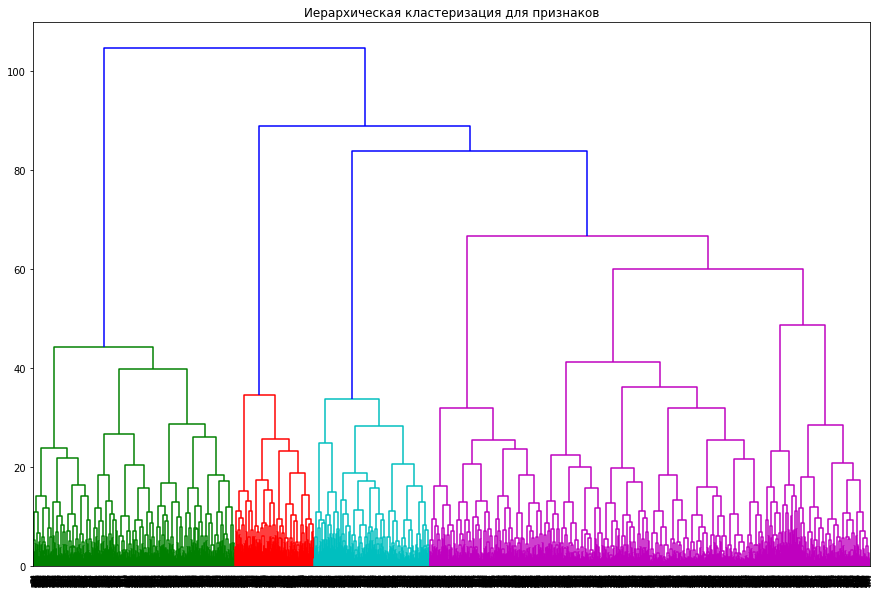

In [24]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для признаков')
plt.show()

<a name="4.3"> На основании полученного графика предположим, какое количество кластеров можно выделить: </a>

<font color='red'>~~Сколько кластеров, судя по дендрограмме?~~ </font>


<font color='purple'> Предложенное оптимальное число кластеров - 4. </font>

<font color='green'>Да, верно. </font>


<a name="4.3"> Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. </a> Договоримся за число кластеров принять n=5. 

In [41]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)
X['cluster_km'] = labels

<font color='red'>~~Кластеризацию также проводить без столбца churn.~~ </font>


<font color='purple'> Внесла изменения, теперь столбец 'Churn' присоединяю в конце, при выводе сгруппированной таблицы. </font>

<a name="4.4"> Посмотрим на средние значения признаков для кластеров. </a> 

In [42]:
clusters_5 = X.copy()
clusters_5['Churn'] = y
clusters_5.groupby(by='cluster_km').agg({'gender': 'count'})

,gender
cluster_km,
0,1011
1,385
2,505
3,1262
4,837


In [43]:
print(clusters_5.groupby(by='cluster_km').mean())

              gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km                                                               
0           0.502473       0.959446  0.783383       0.574679  1.000000   
1           0.522078       0.862338  0.470130       0.306494  0.000000   
2           0.495050       0.000000  0.463366       0.079208  1.000000   
3           0.485737       1.000000  0.350238       0.240095  1.000000   
4           0.560335       0.976105  0.356033       0.229391  0.998805   

            Contract_period  Group_visits        Age  \
cluster_km                                             
0                 10.884273      0.543027  29.980218   
1                  4.787013      0.425974  29.301299   
2                  2.352475      0.215842  28.477228   
3                  1.948494      0.341521  28.167987   
4                  2.665472      0.473118  30.127838   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km 

На основе полученных кластеров выделим группы клиентов:

   -   Кластер 3 - группа с самой высокой долей оттока - 51%:
   
       - **те, кто живет или работает рядом с фитнес-центром**
       - средний возраст 28 лет - клиенты **моложе**, чем типичный пользователь фитнес-сети
       - чаще всего **не сотрудник компании-партнера**
       - это клиенты, чаще всего приходящие **не через акции "приведи друга"**
       - это клиенты, пришедшие на **короткий** контракт  (1-3 месяца)
       - это клиенты, **реже посещающие групповые тренировки**, и в принципе **реже посещающие зал**
       - **средний лайфтайм такого клиента составляет 2.5 месяца** - то есть клиент не успевает конвертироваться в лояльного пользователя сети
       - это клиенты, **тратящие меньше на доп.услуги** (возможно, это следствие маленького лайфтайма)   
   
    _____________________________________
 
   -   Кластер 2  - доля оттока 44%:
       - **те, кто живет или работает НЕ рядом с фитнес-центром**
       - средний возраст 28 лет - клиенты **моложе**, чем типичный пользователь фитнес-сети
       - в половине случаев клиенты являются **сотрудниками компании-партнера**
       - это клиенты, чаще всего приходящие **не через акции "приведи друга"**
       - это клиенты, пришедшие на **короткий** контракт  (1-3 месяца)
       - это клиенты, **реже посещающие групповые тренировки**, и в принципе **реже посещающие зал**
       - это клиенты, **тратящие меньше на доп.услуги** (возможно, это следствие маленького лайфтайма)
       - **средний лайфтайм такого клиента составляет ~3 месяца** - то есть клиент не успевает конвертироваться в лояльного пользователя сети
    __________________________________________    

   -  Кластер 1 - доля оттока - 27%: 
       - средний возраст 29 лет
       - это клиенты, пришедшие на **короткий** контракт  (3-6 месяца) -  - группа с долей оттока - 27%:
       - это клиенты, часто **живущие или работающие рядом с фитнес-центром**
       - в половине случаев клиенты этой группы являются **сотрудниками компании-партнера**
       - это клиенты, приходящие **через акции "приведи друга"** только в трети случаев
       - **средний лайфтайм такого клиента составляет 4 месяца** 
       - **относительно часто посещающие групповые тренировки**
    __________________________________________
   -  Кластер 0 - доля оттока - 3%: 
       - средний возраст 30 лет
       - это клиенты, чаще всего **живущие или работающие рядом с фитнес-центром**
       - чаще всего клиенты являются **сотрудниками компании-партнера**
       - это клиенты, приходящие **через акции "приведи друга"** больше чем в половине случаев
       - это клиенты на долгих контрактах - от 6 до 12 месяцев
       - эта группа клиентов **чаще других посещает групповые тренировки**
       - это клиенты, **тратящие на доп.услуги в среднем больше** 
       - **средний лайфтайм такого клиента составляет почти 5 месяцев** 
    ________________________________________ 
    
   -  Кластер 4 - доля оттока - 7%:    
       - средний возраст 30 лет
       - это клиенты, чаще всего **живущие или работающие рядом с фитнес-центром**
       - в трети случаев клиенты этой группы являются **сотрудниками компании-партнера**
       - только пятая часть кластера пришла **через акции "приведи друга"**
       - это клиенты, пришедшие на **короткий** контракт  (3 месяца) 
       - эта группа клиентов **чаще других посещает групповые тренировки**
       - это клиенты, **тратящие на доп.услуги в среднем больше** 
       - **средний лайфтайм такого клиента составляет почти 5 месяцев** 
       
       
 У кластеров 2 и 3 высокий показатель оттока. То есть по сути, выше - портрет "ушедшего" пользователя, и его характеристики можно анализировать и в дальнейшем предложить меры по снижению оттока.

<a name="4.5"> Построим распределения признаков для кластеров. </a> 

Для бинарных признаков рассмотрим доли в зависимости от кластера:

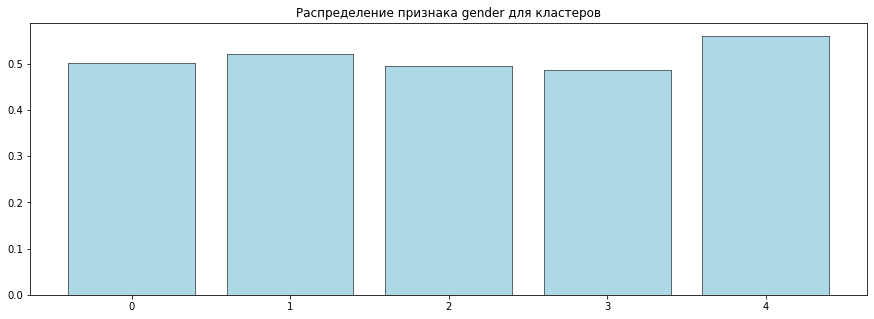

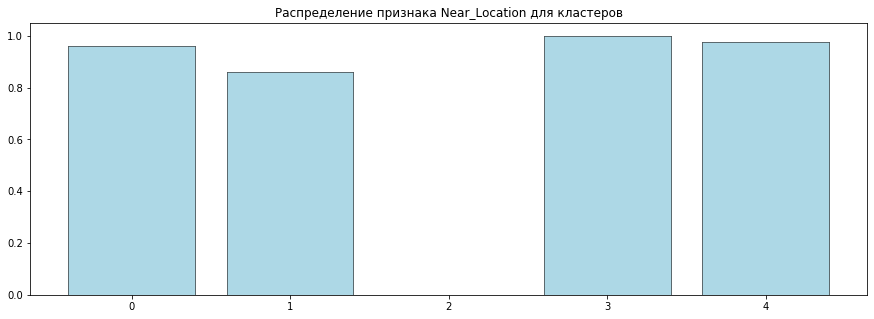

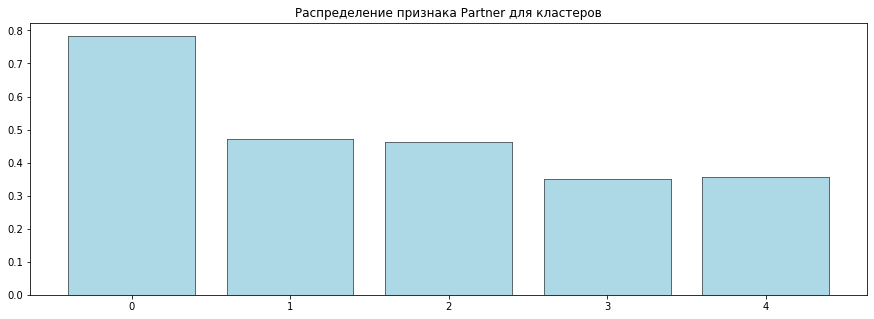

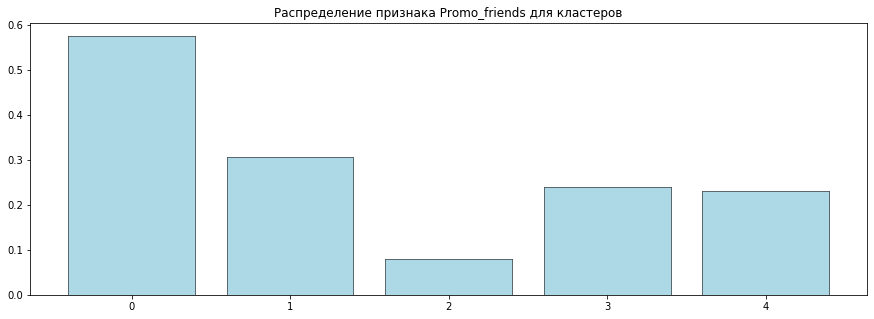

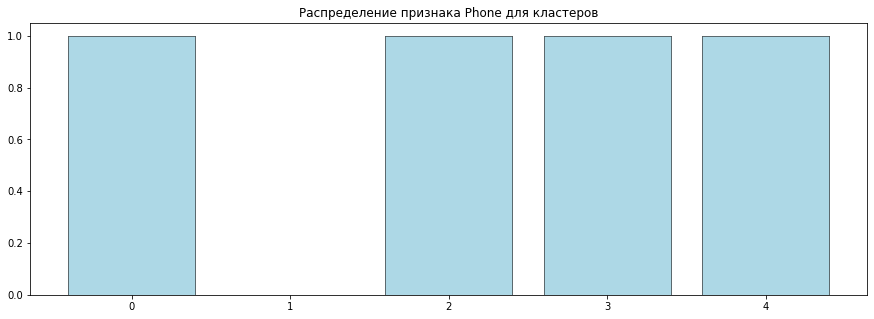

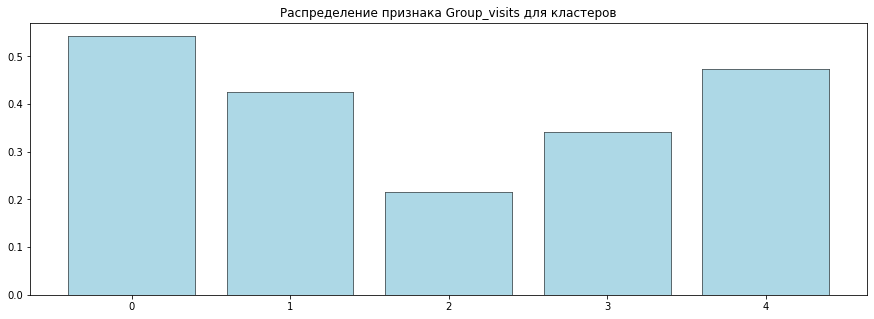

In [28]:
clusters = np.sort(clusters_5['cluster_km'].unique())
for col in ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']:
    plt.figure(figsize=(15, 5))
    for cluster in clusters:
        df = clusters_5.groupby(by='cluster_km').mean()
        plt.bar(df.index, df[col], linewidth=0.5, edgecolor=".2", color = 'lightblue')
    plt.title('Распределение признака ' + col + ' для кластеров')
    plt.show()   

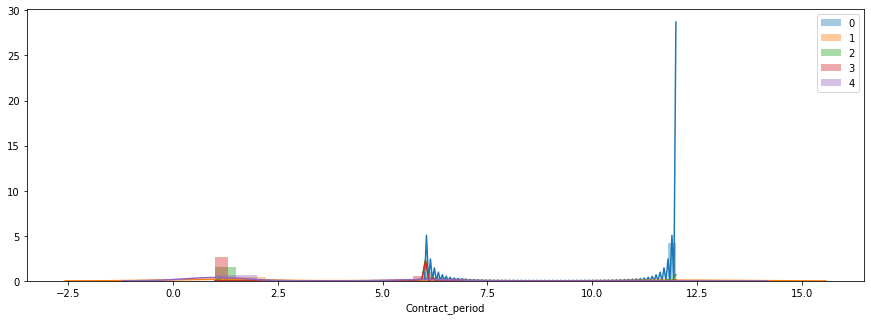

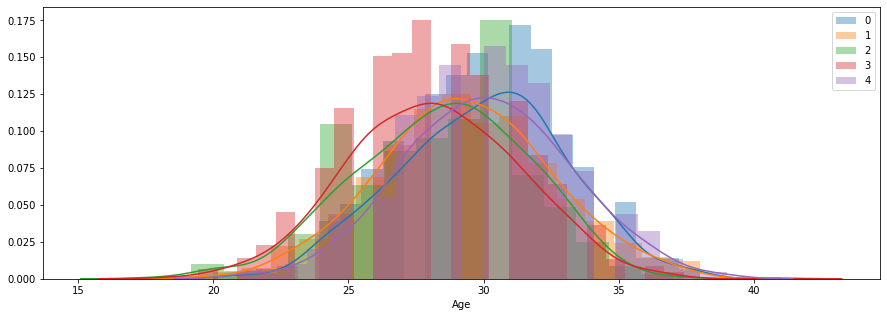

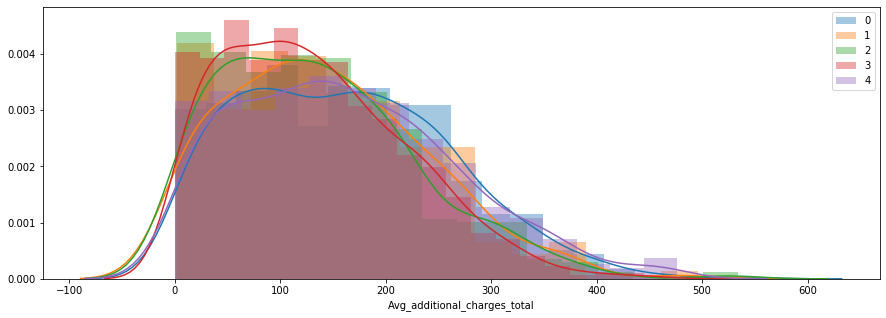

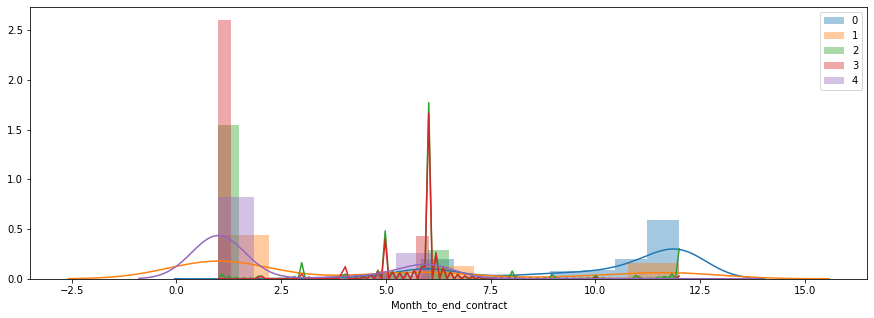

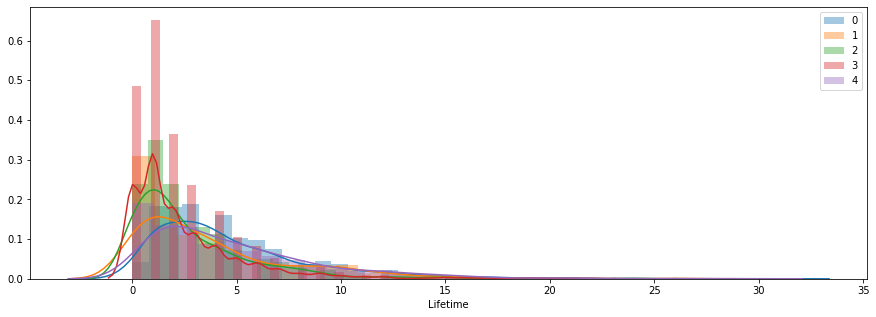

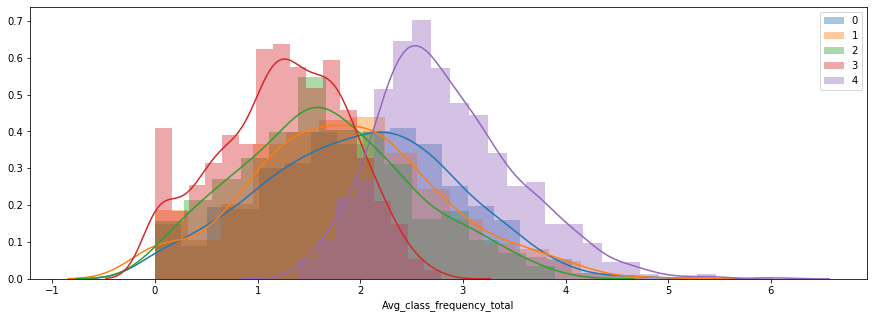

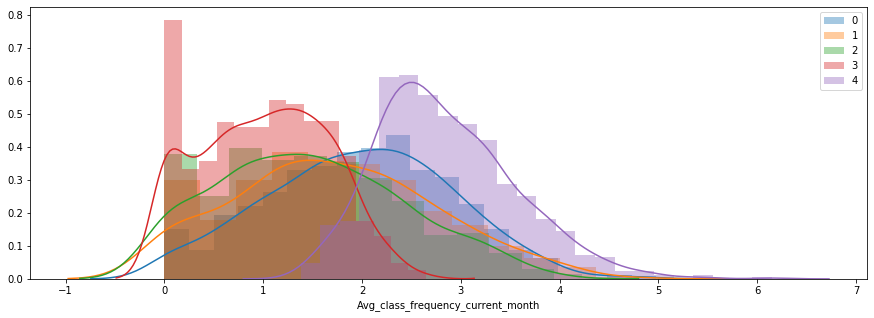

In [29]:
columns = ['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
for col in columns:
    plt.figure(figsize=(15, 5))
    for cluster in clusters:
        df = clusters_5[clusters_5['cluster_km'] == cluster]
        sns.distplot(df[col])
    plt.legend(labels = clusters)
    plt.show()    

In [30]:
columns = ['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

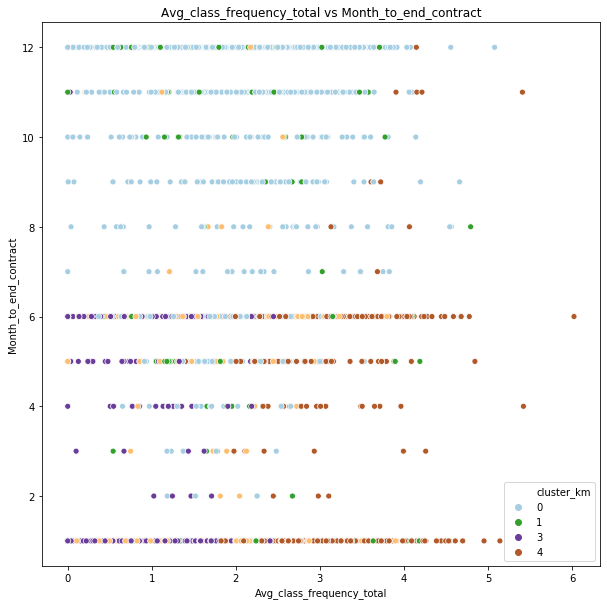

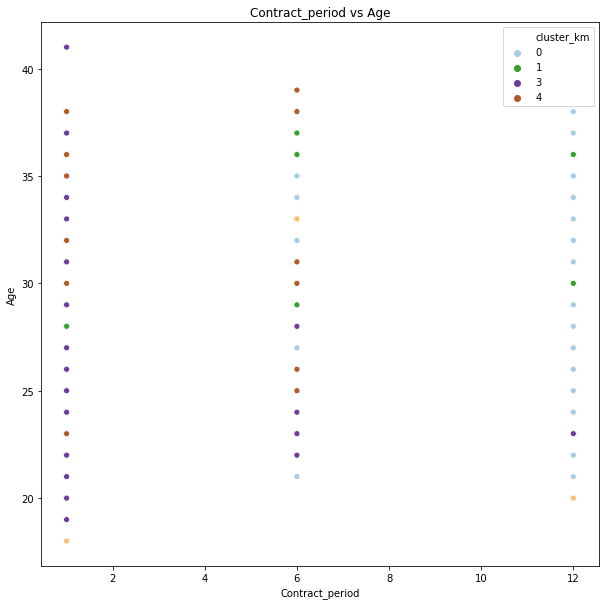

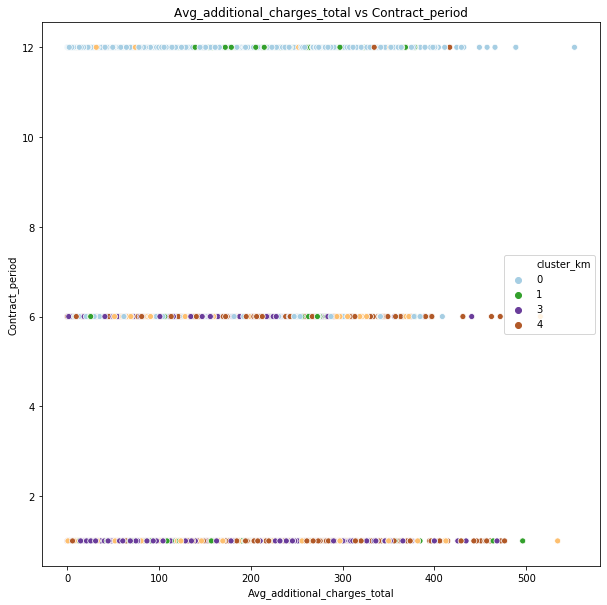

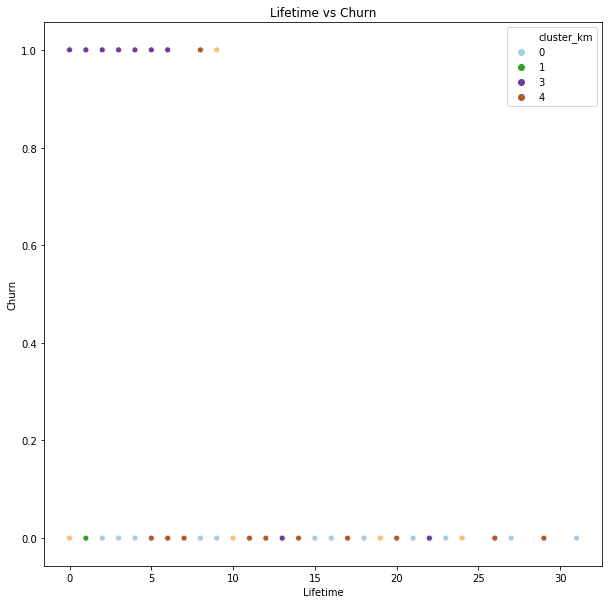

In [31]:
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
    
show_clusters_on_plot(clusters_5, 'Avg_class_frequency_total', 'Month_to_end_contract', 'cluster_km')
show_clusters_on_plot(clusters_5, 'Contract_period', 'Age', 'cluster_km')
show_clusters_on_plot(clusters_5, 'Avg_additional_charges_total', 'Contract_period', 'cluster_km')
show_clusters_on_plot(clusters_5, 'Lifetime', 'Churn', 'cluster_km')

В целом графики подтверждают сделанные ранее выводы.
Можно добавить, что 
 - молодые люди склонны выбирать абонементы на короткий срок
 - на `scatterplot` для признаков `Avg_class_frequency_total` и `Month_to_end_contract` можно увидеть, как падает частота посещений у клиентов на длительном контракте - 6 или 12 месяцев. 

<font color='green'>Графики замечательные :) </font>


<a name="4.6"> Для каждого полученного кластера посчитаем долю оттока.</a> 

In [32]:
cluster_churn = gym_churn.groupby('cluster_km').agg({'Churn': 'mean'})
cluster_churn.applymap("{0:.1%}".format)

KeyError: 'cluster_km'

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(cluster_churn.index, cluster_churn['Churn'], linewidth=0.5, edgecolor=".2", color = 'lightblue')
plt.title('Доля оттока для кластеров')
plt.show()  

Выделется один кластер с высокой долей оттока.

### Шаг 5. Выводы и рекомендации по работе с клиентами

**Основные выводы:**

- нет зависимости между уходом клиента и его полом или наличием его телефона в базе клиентов
- есть связь между уходом клиента и тем, являлся ли клиент сотрудником компании-партнера
- есть зависимость между вероятностью оттока и тем фактом, пришел ли он по акции "приведи друга"
- есть зависимость между вероятностью оттока и тем, живет/работает ли он недалеко от центра
- есть зависимость между вероятностью оттока и тем, посещал ли он групповые занятия


- ушедших клиентов в подавляющем большинстве случаев был короткий абонемент на месяц
- частота посещения зала у ушедших в среднем была ниже, чем у тех, кто остался
- ушедшие клиенты в среднем моложе оставшихся
- короткий lifetime у ушедших клиентов обусловлен короткими абонементами у этих клиентов, и его недостаточно для конвертации клиента в постоянного пользователя центра
- в среднем траты на доп.услуги ниже у ушедших клиентов

Остающийся клиент это:
 - обладатель 12-месячного абонемента, сотрудник компании-партнера, участник промо-программы, посетитель групповых занятий
 
 либо
 
 
 - обладатель абонемента на 3 месяца, но продолжающий занятия и продлевающий контракт


**Рекомендации для стратегии взаимодействия с пользователями и их удержания:**

- необходимо стимулировать частоту посещения центра в  начале контракта (в первые месяцы) - предоставлять бесплатные занятия с тренером, пробные групповые занятия, возможно ввести пообщрения за регулярное посещение центра без пропусков в виде бесплатаных бонусных услуг (или подарков) 


- необходимо стимулировать текущих клиентов использовать акцию "приведи друга" (возможно, проводить какие-то ивенты, куда можно приводить друзей, либо вводить бонусы за каждого привлеченного друга - в виде продления текущего контракта для того, кто привлек нового клиента)


- необходимо развивать канал привлечения через компании-партнеры, расположенные ближе к центрам сети (и не тратить маркетинговые ресурсы на тех, кто живет и работает не близко к центрам)


- необходимо отслеживать вовлеченность в групповые занятия, и в случае прекращения клиентом посещения того  или иного группового занятия, стараться предлагать альтернативы


- приоритетно продавать длинные контракты (разработать программы рассрочки для тех, кто выбирает короткие абонементы из-за затруднений с оплатой полного контракта на длительный период), апгрейдить на выгодных условиях текущий короткий абонемент до длительного

# Итоговый комментарий

~~Спасибо, ты провела прекрасное исследование, осталось его немного доработать. Будут вопросы – пиши :)~~

Успехов в дальнейших проектах! :)